In [17]:
# Step 0. Import libraries, custom modules and logging
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, 
                             f1_score,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay,
                             DetCurveDisplay)
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [19]:
# Step 1. Load data and get a first view -------------------------------
# 1.1 Read from source and get basic info
df_raw = pd.read_csv('heights.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sex     1050 non-null   object 
 1   height  1050 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.5+ KB


In [20]:
# 1.2 Get a sample
display(df_raw.sample(5, random_state=66))

,sex,height
879,Male,70.0
517,Male,69.0
894,Female,67.0
931,Male,72.0
740,Female,64.0


In [21]:
# Step 2. Prepara the dataset for analysis
# 2.1 Make transformations using a pipeline
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .rename(columns={'sex':'target'})
    .astype({'target': "category"})
  
)

In [22]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   target  1050 non-null   category
 1   height  1050 non-null   float64 
dtypes: category(1), float64(1)
memory usage: 9.5 KB


In [23]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2,
                                     stratify= df['target'])
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 362 to 686
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   target  840 non-null    category
 1   height  840 non-null    float64 
dtypes: category(1), float64(1)
memory usage: 14.1 KB


In [24]:
display(df_train.describe().T)
display(df_train.describe(include= "category").T)

,count,mean,std,min,25%,50%,75%,max
height,840.0,68.347764,4.211153,50.0,66.0,68.5,71.0,82.677165


,count,unique,top,freq
target,840,2,Male,650


In [27]:
table = pd.concat(
    [df_train["target"].value_counts(),
     df_train["target"].value_counts(normalize=True)], axis = 1

)
display(table)
print(f"Sum: {len(df_train["target"])}")

,count,proportion
target,,
Male,650,0.77381
Female,190,0.22619


Sum: 840


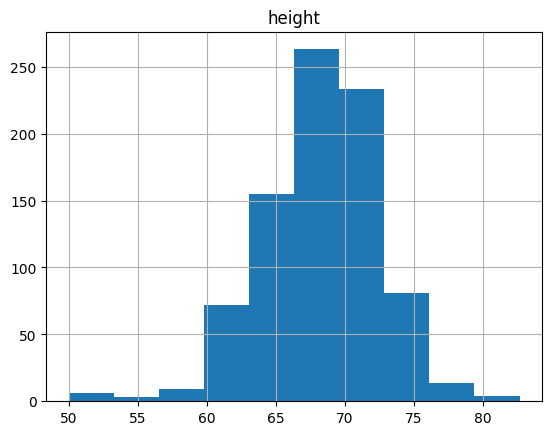

In [28]:
df_train.hist()

plt.show()

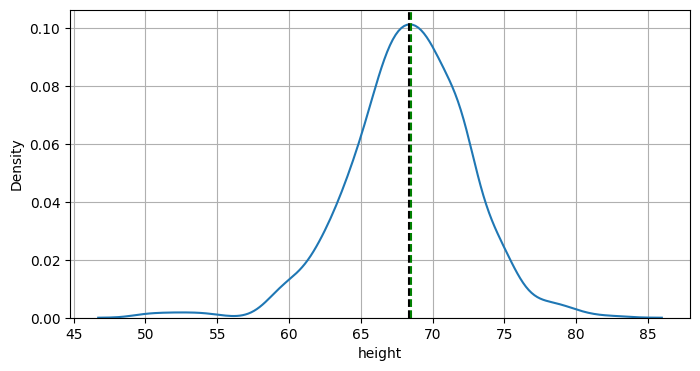

In [30]:
# 3.4 Perform univariate analysis on numerical variables using kde
fig, ax = plt.subplots(1,1, figsize=(8,4))
sns.kdeplot(data=df_train, x='height', ax=ax)
ax.axvline(x=df_train['height'].mean(), color='k', linestyle='--')
ax.axvline(x=df_train['height'].median(), color='g', linestyle='--')
ax.grid(True)
plt.show()

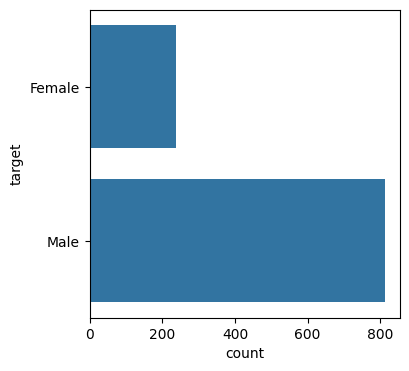

In [33]:
fig, ax = plt.subplots(figsize= (4, 4))
sns.countplot(data= df, y= 'target', ax= ax)
plt.show()

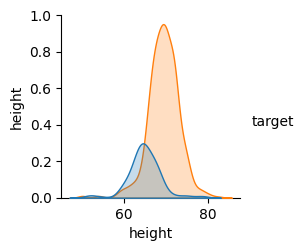

In [34]:
sns.pairplot(data= df_train, diag_kind="kde", hue="target")
plt.show()

In [35]:
# Step 4. Experiment with models
# 4.1 Split features and reponse
X_train = df_train.drop('target', axis=1).reset_index(drop=True) # Independent variable
y_train = df_train['target'].reset_index(drop=True)
X_test = df_test.drop('target', axis=1).reset_index(drop=True)
y_test = df_test['target'].reset_index(drop=True) # Dependent variable

In [36]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [37]:
# 4.2 Simple model
# 4.1 Create a naive model, by guessing the outcome, then evaluate
y_naive = np.random.choice(
    df_train['target'].unique().tolist(), size=len(df_train)
)
y_naive_enc = label_encoder.transform(y_naive)
print(f'Accuracy: {accuracy_score(y_train_enc, y_naive_enc):.2f}')

Accuracy: 0.51


In [38]:
df_train.groupby("target", observed=False)["height"].agg(["mean", "std"])

,mean,std
target,,
Female,64.847822,3.899699
Male,69.370824,3.723219


In [39]:
y_interval = (
    df_train["height"].apply(lambda x: "Male" if x >= 62 else "Female").tolist()
)
y_interval_enc = label_encoder.transform(y_interval)
print(f'Accuracy: {accuracy_score(y_train_enc, y_interval_enc):.3f}')
print(f'f1 score: {f1_score(y_train_enc, y_interval_enc):.3f}')

Accuracy: 0.779
f1 score: 0.871


In [40]:
my_table = pd.DataFrame({"cutoff": [], "accuaracy":[]})
for i in range(62,76):
    y_temp = (
         df_train["height"].apply(lambda x: "Male" if x >= i else "Female").tolist()
    )
    y_temp_enc = label_encoder.transform(y_temp)
    metric = round(accuracy_score(y_train_enc, y_interval_enc), 2)
    new_row = pd.DataFrame({"cutoff": [i], "accuaracy":[metric]})
    my_table = pd.concat([new_row, my_table])

my_table.reset_index(drop=True)

,cutoff,accuaracy
0,75.0,0.78
1,74.0,0.78
2,73.0,0.78
3,72.0,0.78
4,71.0,0.78
5,70.0,0.78
6,69.0,0.78
7,68.0,0.78
8,67.0,0.78
9,66.0,0.78


In [41]:
y_cutoff =(
    df_train["height"].apply(lambda x : "Male" if x >= 64 else "Female").tolist()
)

pred = pd.DataFrame({"pred": y_cutoff})
display(pd.crosstab(y_train, pred["pred"]))
display(pd.crosstab(y_train, pred["pred"], normalize="index"))

pred,Female,Male
target,,
Female,60,130
Male,34,616


pred,Female,Male
target,,
Female,0.315789,0.684211
Male,0.052308,0.947692


In [42]:
clf_log_reg = LogisticRegression(class_weight="balanced")
clf_log_reg.fit(X_train, y_train_enc)

LogisticRegression(class_weight='balanced')

In [43]:
y_pred = clf_log_reg.predict(X_test)

In [44]:
y_pred

array([1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1])

In [45]:
print(f'Accuracy: {accuracy_score(y_test_enc, y_pred):.3f}')

Accuracy: 0.710


In [46]:
pred = pd.DataFrame({"pred": y_pred})
display(pd.crosstab(y_train, pred["pred"]))
display(pd.crosstab(y_train, pred["pred"], normalize="index"))

pred,0,1
target,,
Female,28,22
Male,53,107


pred,0,1
target,,
Female,0.56000,0.44000
Male,0.33125,0.66875


In [15]:
reg_lin = LinearRegression()
reg_lin.fit(X_train, y_train)
y_pred = reg_lin.predict(X_test)

In [ ]:
print(f"MSE: {mean_squared_error(y_test, y_pred)}") # mean squuared error
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}") 
print(f"MAE: {mean_absolute_error(y_test, y_pred)}") # mean absolute error
print(f"R2: {r2_score(y_test, y_pred)}") 

In [ ]:
plt.scatter(x= y_test, y= y_pred, c='k')
plt.plot([70,230], [70,230], c='r')
plt.axis('equal')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.show()

In [ ]:
resid = y_test - y_pred
plt.scatter(x= y_pred, y= resid)
plt.axhline(0, linestyle= "--")
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.show()

In [ ]:
# Model
print(f"mort = {reg_lin.intercept_:.1f} {reg_lin.coef_[0]:1f}*lat")

In [ ]:
# Step 1. Load data and get a first view -------------------------------
# 1.1 Read from source and get basic info
df_raw_1 = pd.read_csv('skincancer.csv')
df_raw_1.info()

In [21]:
# Step 2. Prepara the dataset for analysis
# 2.1 Make transformations using a pipeline
df_interim_1 = (
    df_raw_1
    .copy()
    .set_axis(
        df_raw_1.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .rename(columns={'mort':'target'})
    .astype({'target': np.float16})
    .iloc[:,1:]
)

In [ ]:
# 2.2 Create the final dataset with the target in front, show result
df_1 = (
    df_interim_1
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim_1.columns.to_list() if c not in ['target']]
        )
    )
)
df_1.info()

In [ ]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_trai, df_tes = train_test_split(df_1, 
                                     random_state=2024, 
                                     test_size=0.2)
df_trai = df_trai.reset_index(drop=True).sort_values(by='target')
df_trai.info()

In [ ]:
display(df_1.describe().T)

In [ ]:
df_trai.hist()
plt.show()

In [ ]:
sns.pairplot(data= df_trai, diag_kind="kde")
plt.show()

In [27]:
# Step 4. Experiment with models
# 4.1 Split features and reponse
X_trai = df_trai.drop('target', axis=1).reset_index(drop=True) # Independent variable
y_trai = df_trai['target'].reset_index(drop=True)
X_tes = df_tes.drop('target', axis=1).reset_index(drop=True)
y_tes = df_tes['target'].reset_index(drop=True) # Dependent variable

In [28]:
reg_mlin = LinearRegression()
reg_mlin.fit(X_trai, y_trai)
y_mpred = reg_mlin.predict(X_tes)

In [ ]:
print(f"MSE: {mean_squared_error(y_tes, y_mpred)}") # mean squuared error
print(f"RMSE: {np.sqrt(mean_squared_error(y_tes, y_mpred))}") 
print(f"MAE: {mean_absolute_error(y_tes, y_mpred)}") # mean absolute error
print(f"R2: {r2_score(y_tes, y_mpred)}") 

# R2 explains what percentage of the predicted actual variance

In [ ]:
# Explain model
importance = permutation_importance(reg_mlin, X_trai, y_trai)
importance_df = pd.DataFrame(importance.importances.T, columns= X_trai.columns)
ax = importance_df.plot.box(vert = False)
ax.axvline(x= 0, color= 'k', linestyle= '--')
ax.set_title('Permutation importance (train set)')
ax.grid(True)
plt.show()

In [ ]:
# Model
print(f"mort = {reg_mlin.intercept_:.1f} {reg_mlin.coef_[0]:1f}*lat +{reg_mlin.coef_[1]:1f}*ocean {reg_mlin.coef_[2]:1f}*long")